In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
import os
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Recommendation libraries (CPU-friendly)
try:
    from surprise import SVD, Dataset, Reader, accuracy
    from surprise.model_selection import cross_validate, train_test_split as surprise_split
    import surprise.dump as surprise_dump # For saving models
    SURPRISE_AVAILABLE = True
except ImportError:
    print("⚠️ Surprise library not found. Install with: pip install scikit-surprise")
    SURPRISE_AVAILABLE = False

# Add project root to path (Robust method)
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Custom modules
try:
    from scripts.data_loader import DataLoader
    print("✓ Successfully imported DataLoader from scripts")
except ImportError as e:
    print(f"❌ Import Failed: {e}")
    print("Make sure 'data_loader.py' is inside the 'scripts' folder.")

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✓ All imports successful")
print(f"✓ Surprise available: {SURPRISE_AVAILABLE}")

✓ Successfully imported DataLoader from scripts
✓ All imports successful
✓ Surprise available: True


In [2]:
# Load original data (Fix: point to parent data folder)
loader = DataLoader(raw_data_path='../data/raw')
ecom_data = loader.load_brazilian_ecommerce()

# Load engineered features (Fix: point to parent data folder)
processed_path = Path('../data/processed')
user_features = pd.read_csv(processed_path / 'user_features.csv')
product_features = pd.read_csv(processed_path / 'product_features.csv')

print("\n✓ Data loaded successfully")
print(f"\nUsers: {len(user_features):,}")
print(f"Products: {len(product_features):,}")
print(f"Orders: {len(ecom_data['orders']):,}")
print(f"Order Items: {len(ecom_data['order_items']):,}")


✓ Data loaded successfully

Users: 99,441
Products: 32,951
Orders: 99,441
Order Items: 112,650


In [3]:
# Merge orders with order items to get customer-product interactions
interactions = ecom_data['orders'][['order_id', 'customer_id']].merge(
    ecom_data['order_items'][['order_id', 'product_id', 'price']],
    on='order_id',
    how='inner'
)

# Add review scores
interactions = interactions.merge(
    ecom_data['reviews'][['order_id', 'review_score']],
    on='order_id',
    how='left'
)

# Fill missing review scores with neutral value (3)
interactions['review_score'] = interactions['review_score'].fillna(3)

# Create implicit rating: combination of purchase (binary) and review score
# Rating = (review_score * 2) to scale 1-5 stars to 2-10 rating
interactions['rating'] = interactions['review_score'] * 2

print("\n📊 Interaction Matrix Statistics:")
print(f"Total interactions: {len(interactions):,}")
print(f"Unique customers: {interactions['customer_id'].nunique():,}")
print(f"Unique products: {interactions['product_id'].nunique():,}")
print(f"\nRating distribution:")
print(interactions['rating'].value_counts().sort_index())
print(f"\nSparsity: {(1 - len(interactions) / (interactions['customer_id'].nunique() * interactions['product_id'].nunique())) * 100:.2f}%")

display(interactions.head(10))


📊 Interaction Matrix Statistics:
Total interactions: 113,314
Unique customers: 98,666
Unique products: 32,951

Rating distribution:
rating
2.0     14235
4.0      3874
6.0     10365
8.0     21315
10.0    63525
Name: count, dtype: int64

Sparsity: 100.00%


,order_id,customer_id,product_id,price,review_score,rating
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,4.0,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,118.70,4.0,8.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,159.90,5.0,10.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,5.0,10.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,65266b2da20d04dbe00c5c2d3bb7859e,19.90,5.0,10.0
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,060cb19345d90064d1015407193c233d,147.90,4.0,8.0
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,a1804276d9941ac0733cfd409f5206eb,49.90,2.0,4.0
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,4520766ec412348b8d4caa5e8a18c464,59.99,5.0,10.0
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,ac1789e492dcd698c5c10b97a671243a,19.90,1.0,2.0
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,9a78fb9862b10749a117f7fc3c31f051,149.99,5.0,10.0


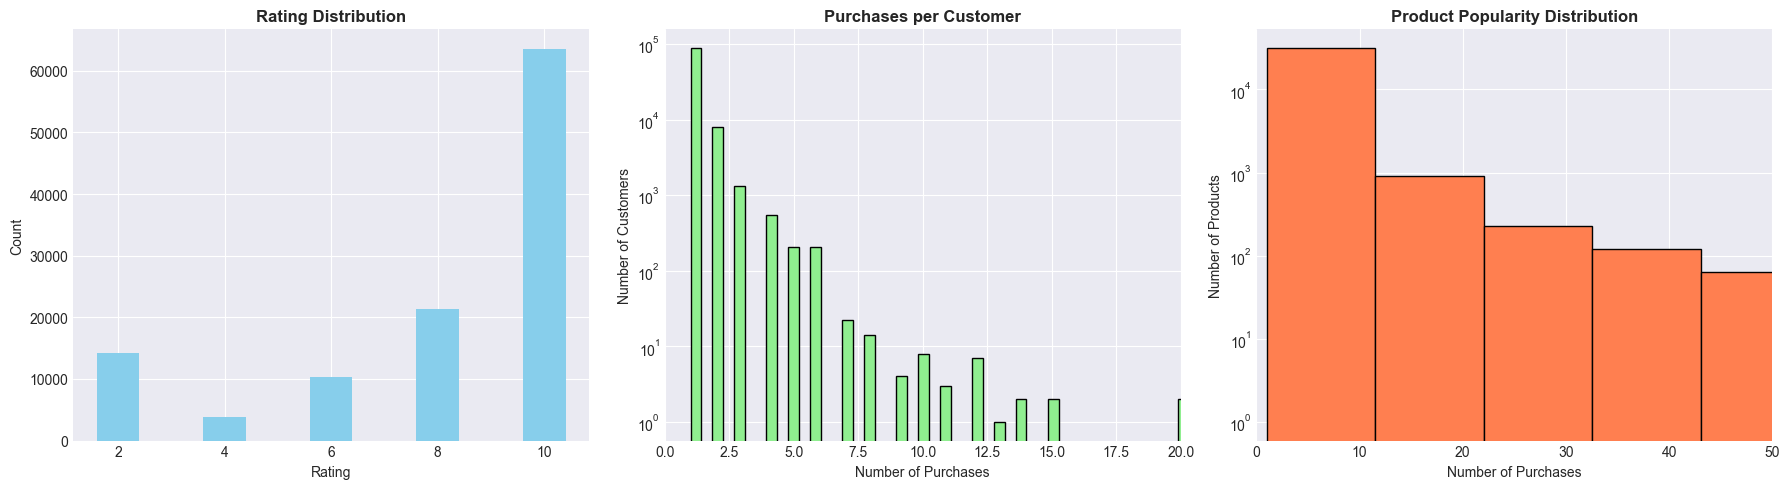


📈 Key Statistics:
Average purchases per customer: 1.15
Median purchases per customer: 1
Average purchases per product: 3.44
Median purchases per product: 1


In [4]:
# Visualize interactions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rating distribution
rating_counts = interactions['rating'].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color='skyblue')
axes[0].set_title('Rating Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Purchases per customer
purchases_per_customer = interactions.groupby('customer_id').size()
axes[1].hist(purchases_per_customer, bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title('Purchases per Customer', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xlim(0, 20)
axes[1].set_yscale('log')

# Product popularity
product_popularity = interactions.groupby('product_id').size().sort_values(ascending=False)
axes[2].hist(product_popularity, bins=50, color='coral', edgecolor='black')
axes[2].set_title('Product Popularity Distribution', fontweight='bold', fontsize=12)
axes[2].set_xlabel('Number of Purchases')
axes[2].set_ylabel('Number of Products')
axes[2].set_xlim(0, 50)
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n📈 Key Statistics:")
print(f"Average purchases per customer: {purchases_per_customer.mean():.2f}")
print(f"Median purchases per customer: {purchases_per_customer.median():.0f}")
print(f"Average purchases per product: {product_popularity.mean():.2f}")
print(f"Median purchases per product: {product_popularity.median():.0f}")

In [5]:
## . Model 1: Collaborative Filtering (Matrix Factorization) Using SVD (Singular Value Decomposition) - CPU optimized
if not SURPRISE_AVAILABLE:
    print("⚠️ Please install surprise library: pip install scikit-surprise")
else:
    # Prepare data for Surprise
    reader = Reader(rating_scale=(2, 10)) # Our ratings are 2-10
    
    # Create dataset from dataframe
    surprise_data = Dataset.load_from_df(
        interactions[['customer_id', 'product_id', 'rating']], 
        reader
    )
    
    # Train-test split
    trainset, testset = surprise_split(surprise_data, test_size=0.2, random_state=42)
    
    print("✓ Data prepared for collaborative filtering")
    print(f"Training set size: {trainset.n_ratings:,}")
    print(f"Test set size: {len(testset):,}")

✓ Data prepared for collaborative filtering
Training set size: 90,651
Test set size: 22,663


In [6]:
if SURPRISE_AVAILABLE:
    # Train SVD model (CPU-friendly, uses optimized BLAS)
    print("\n🔄 Training SVD model (this may take a few minutes on CPU)...")
    
    svd_model = SVD(
        n_factors=50,      # Number of latent factors (lower = faster)
        n_epochs=20,       # Number of iterations
        lr_all=0.005,      # Learning rate
        reg_all=0.02,      # Regularization
        random_state=42,
        verbose=True
    )
    
    # Fit model
    svd_model.fit(trainset)
    
    print("\n✓ SVD model trained successfully!")


🔄 Training SVD model (this may take a few minutes on CPU)...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

✓ SVD model trained successfully!



📊 Evaluating SVD Model...

✓ SVD Performance:
  RMSE: 2.5412 (Root Mean Squared Error)
  MAE: 1.9974 (Mean Absolute Error)


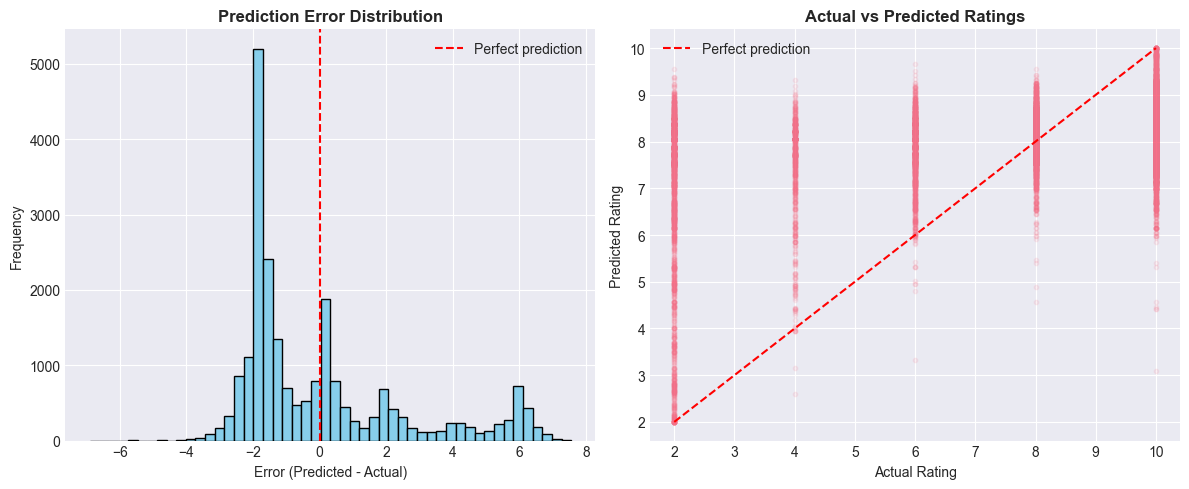

In [7]:
if SURPRISE_AVAILABLE:
    # Evaluate on test set
    print("\n📊 Evaluating SVD Model...")
    
    predictions = svd_model.test(testset)
    
    # Calculate metrics
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    print(f"\n✓ SVD Performance:")
    print(f"  RMSE: {rmse:.4f} (Root Mean Squared Error)")
    print(f"  MAE: {mae:.4f} (Mean Absolute Error)")
    
    # Distribution of prediction errors
    errors = [pred.est - pred.r_ui for pred in predictions]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
    plt.title('Prediction Error Distribution', fontweight='bold')
    plt.xlabel('Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--', label='Perfect prediction')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    actual = [pred.r_ui for pred in predictions]
    predicted = [pred.est for pred in predictions]
    plt.scatter(actual, predicted, alpha=0.1, s=10) # Use lower alpha for dense plots
    plt.plot([2, 10], [2, 10], 'r--', label='Perfect prediction')
    plt.title('Actual vs Predicted Ratings', fontweight='bold')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
if SURPRISE_AVAILABLE:
    # Generate recommendations for a sample user
    def get_top_n_recommendations(model, user_id, n=10):
        """
        Get top N product recommendations for a user
        """
        # Get all products
        all_products = interactions['product_id'].unique()
        
        # Get products user has already purchased
        purchased_products = interactions[interactions['customer_id'] == user_id]['product_id'].unique()
        
        # Get products to recommend (not yet purchased)
        products_to_predict = [p for p in all_products if p not in purchased_products]
        
        # Predict ratings for all unseen products
        predictions = [model.predict(user_id, product_id) for product_id in products_to_predict]
        
        # Sort by predicted rating
        predictions.sort(key=lambda x: x.est, reverse=True)
        
        # Return top N
        top_n = predictions[:n]
        
        return [(pred.iid, pred.est) for pred in top_n]

    # Test with a random user
    sample_user = interactions['customer_id'].iloc[100]
    
    print(f"\n🎯 Generating recommendations for user: {sample_user}")
    print("\nUser's purchase history:")
    user_history = interactions[interactions['customer_id'] == sample_user][['product_id', 'rating']].head(5)
    display(user_history)
    
    print("\n💡 Top 10 Recommended Products (SVD):")
    recommendations = get_top_n_recommendations(svd_model, sample_user, n=10)
    
    rec_df = pd.DataFrame(recommendations, columns=['product_id', 'predicted_rating'])
    
    # Add product details
    rec_df = rec_df.merge(
        product_features[['product_id', 'category', 'avg_price', 'avg_rating', 'popularity_score']],
        on='product_id',
        how='left'
    )
    
    display(rec_df)


🎯 Generating recommendations for user: fee181bf648906d1c57f84f216976286

User's purchase history:


,product_id,rating
100,c827fb43ad0fb8708f34c2911fdc164b,10.0



💡 Top 10 Recommended Products (SVD):


,product_id,predicted_rating,category,avg_price,avg_rating,popularity_score
0,73326828aa5efe1ba096223de496f596,9.819002,food,82.611481,4.833333,0.986715
1,6a8631b72a2f8729b91514db87e771c0,9.749164,electronics,26.641935,4.709677,0.979951
2,e0cf79767c5b016251fe139915c59a26,9.675403,health_beauty,29.900000,4.477941,0.967930
3,e2e426d1332240070b0a836a854d057b,9.631237,bed_bath_table,37.814286,4.571429,0.967876
4,f7f59e6186e10983a061ac7bdb3494d6,9.630823,housewares,34.900000,4.820513,0.983739
5,d6160fb7873f184099d9bc95e30376af,9.582311,computers,1397.124000,4.571429,0.967876
6,99a4788cb24856965c36a24e339b6058,9.580859,bed_bath_table,88.167131,3.898340,0.933873
7,82a61259a621866c4ba63743da29a342,9.561395,sports_leisure,124.218750,4.750000,0.965040
8,574597aaf385996112490308e37399ce,9.551496,housewares,49.000000,4.833333,0.979169
9,fbc1488c1a1e72ba175f53ab29a248e8,9.547066,perfumery,118.491207,4.620690,0.974334


In [10]:
##  Model 2: Content-Based Filtering ,Recommend similar products based on product features
# Prepare product feature matrix for content-based filtering
print("\n🔧 Preparing content-based filtering...")

# Select relevant features
content_features = product_features[[
    'product_id', 'category', 'avg_price', 'avg_rating', 
    'popularity_score', 'total_sold', 'product_weight_g', 'volume'
]].copy()

# Handle missing values
content_features['avg_rating'] = content_features['avg_rating'].fillna(3.0)
content_features['product_weight_g'] = content_features['product_weight_g'].fillna(content_features['product_weight_g'].median())
content_features['volume'] = content_features['volume'].fillna(content_features['volume'].median())
content_features['category'] = content_features['category'].fillna('unknown')

# One-hot encode category
category_encoded = pd.get_dummies(content_features['category'], prefix='cat')
content_features = pd.concat([content_features, category_encoded], axis=1)
content_features = content_features.drop('category', axis=1)

# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['avg_price', 'avg_rating', 'popularity_score', 'total_sold', 'product_weight_g', 'volume']
content_features[numerical_cols] = scaler.fit_transform(content_features[numerical_cols])

print(f"✓ Feature matrix shape: {content_features.shape}")
print(f"\nFeature columns: {content_features.columns.tolist()[:10]}...")


🔧 Preparing content-based filtering...
✓ Feature matrix shape: (32951, 79)

Feature columns: ['product_id', 'avg_price', 'avg_rating', 'popularity_score', 'total_sold', 'product_weight_g', 'volume', 'cat_agro_industry_and_commerce', 'cat_air_conditioning', 'cat_art']...


In [11]:
# Calculate product similarity matrix (this is CPU intensive, so we'll limit it)
print("\n🔄 Calculating product similarity matrix (may take a minute)...")

# For efficiency, let's work with top 5000 most popular products
top_products = product_features.nlargest(5000, 'total_sold')['product_id'].values
content_features_subset = content_features[content_features['product_id'].isin(top_products)]

# Set product_id as index
product_ids = content_features_subset['product_id'].values
feature_matrix = content_features_subset.drop('product_id', axis=1).values

# Calculate cosine similarity
similarity_matrix = cosine_similarity(feature_matrix)

# Create similarity dataframe
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=product_ids,
    columns=product_ids
)

print(f"✓ Similarity matrix calculated: {similarity_matrix.shape}")
print(f"\nSample similarities:")
sample_product = product_ids[0]
similar_products = similarity_df[sample_product].sort_values(ascending=False).head(6)
print(similar_products)


🔄 Calculating product similarity matrix (may take a minute)...
✓ Similarity matrix calculated: (5000, 5000)

Sample similarities:
2548af3e6e77a690cf3eb6368e9ab61e    1.000000
e5989cd466f0714e1439b95bf6a279da    0.998804
f919da4f716dc149cef4551a322001fd    0.997941
680874c570dad71c0a2844cfbf417054    0.997820
1015f4f024ec3cd0f9516a779ece52dd    0.997107
7c68e7297c7df2535c9f0dcd61007f64    0.996844
Name: 2548af3e6e77a690cf3eb6368e9ab61e, dtype: float64


In [12]:
# Content-based recommendation function
def get_content_based_recommendations(product_id, n=10):
    """
    Get similar products based on content features
    """
    if product_id not in similarity_df.index:
        # Fallback: Product not in our top-5000 matrix
        return pd.DataFrame(columns=['product_id', 'category', 'avg_price', 'avg_rating', 'popularity_score', 'similarity_score'])
    
    # Get similar products
    similar = similarity_df[product_id].sort_values(ascending=False)[1:n+1]  # Exclude itself
    
    # Get product details
    recommendations = product_features[product_features['product_id'].isin(similar.index)][[
        'product_id', 'category', 'avg_price', 'avg_rating', 'popularity_score'
    ]].copy()
    
    # Add similarity score
    recommendations['similarity_score'] = recommendations['product_id'].map(similar)
    recommendations = recommendations.sort_values('similarity_score', ascending=False)
    
    return recommendations

# Test content-based recommendations
sample_product_id = product_ids[10] # Get a sample product

print(f"\n🎯 Content-Based Recommendations for product: {sample_product_id}")
print("\nOriginal Product:")
original = product_features[product_features['product_id'] == sample_product_id][[
    'product_id', 'category', 'avg_price', 'avg_rating'
]]
display(original)

print("\n💡 Similar Products:")
content_recs = get_content_based_recommendations(sample_product_id, n=10)
display(content_recs)


🎯 Content-Based Recommendations for product: 75b4372e69a42f8ae1d908c076f547b2

Original Product:


,product_id,category,avg_price,avg_rating
80,75b4372e69a42f8ae1d908c076f547b2,health_beauty,245.725,3.0



💡 Similar Products:


,product_id,category,avg_price,avg_rating,popularity_score,similarity_score
3740,79938780eb7ffb7289f59a9a283bc06b,health_beauty,59.900,3.000000,0.780266,0.999496
2284,1166c098840d03686b633fe2612c5f2d,health_beauty,105.700,3.000000,0.761086,0.999371
26517,02a97df83a8a100c7d2b14a02aea6a3d,health_beauty,69.900,3.000000,0.787907,0.999268
27971,738121d1a5b54545080cef01275446d8,health_beauty,41.900,3.200000,0.799907,0.999087
2310,d585c50d622ff40b4d69959caa42a5a3,health_beauty,69.990,2.750000,0.746086,0.999024
30165,99d48e31cb95ab20a319faea37066bf0,health_beauty,255.000,3.200000,0.799907,0.998859
14560,22234a1dd91ce8e88c7b108d198c40ad,health_beauty,59.536,3.200000,0.799907,0.998759
29469,04b48e86a968cfe620da1cab5c7556ae,health_beauty,41.390,3.200000,0.799907,0.998743
16810,9fd9505539e1c67c13e4ee824fc1e1cc,health_beauty,34.900,3.000000,0.819586,0.998252
31121,55945cf4a4e6def88dcc8996a581608a,health_beauty,100.575,2.666667,0.786274,0.998127


In [ ]:
##  Model 3: Hybrid Recommendation System Combine collaborative and content-based filtering
if SURPRISE_AVAILABLE:
    def get_hybrid_recommendations(user_id, n=10, collab_weight=0.7, content_weight=0.3):
        """
        Hybrid recommendation: weighted combination of collaborative and content-based
        """
        # Get user's recent purchases
        user_purchases = interactions[interactions['customer_id'] == user_id]
        
        if len(user_purchases) == 0:
            print(f"No purchase history for user {user_id}. Returning top popular items.")
            # Fallback: return top popular items
            return product_features.nlargest(n, 'popularity_score')
        
        # 1. Get collaborative filtering scores
        collab_recs = get_top_n_recommendations(svd_model, user_id, n=50) # Get top 50
        collab_df = pd.DataFrame(collab_recs, columns=['product_id', 'collab_score'])
        
        # Filter to products in our similarity matrix
        collab_df = collab_df[collab_df['product_id'].isin(similarity_df.index)]
        
        # 2. Get content-based scores from user's *last* purchased product
        last_product = user_purchases.sort_values('rating', ascending=False).iloc[0]['product_id']
        
        if last_product in similarity_df.index:
            content_scores = similarity_df[last_product]
            content_df = pd.DataFrame({
                'product_id': content_scores.index,
                'content_score': content_scores.values
            })
            
            # Merge scores
            hybrid_df = collab_df.merge(content_df, on='product_id', how='left')
            hybrid_df['content_score'] = hybrid_df['content_score'].fillna(0) # Fill if no content match
            
            # Normalize scores to 0-1 range
            hybrid_df['collab_score_norm'] = (hybrid_df['collab_score'] - 2) / 8 # (score - min) / (max - min)
            
            # Calculate hybrid score
            hybrid_df['hybrid_score'] = (
                hybrid_df['collab_score_norm'] * collab_weight +
                hybrid_df['content_score'] * content_weight
            )
            
            # Sort by hybrid score
            hybrid_df = hybrid_df.sort_values('hybrid_score', ascending=False).head(n)
            
            # Add product details
            hybrid_df = hybrid_df.merge(
                product_features[['product_id', 'category', 'avg_price', 'avg_rating', 'popularity_score']],
                on='product_id',
                how='left'
            )
            return hybrid_df
        else:
            # Fallback to collaborative filtering only
            print(f"Info: Last product {last_product} not in similarity matrix. Using SVD-only fallback.")
            
            # Merge to get product details
            fallback_df = collab_df.merge(
                product_features[['product_id', 'category', 'avg_price', 'avg_rating', 'popularity_score']],
                on='product_id',
                how='left'
            ).head(n)
            
            # Add missing columns as np.nan so display() works
            fallback_df['content_score'] = np.nan
            fallback_df['hybrid_score'] = np.nan
            
            return fallback_df
    # Test hybrid recommendations
    print("\n🎯 Hybrid Recommendations\n")
    print(f"For user: {sample_user}")
    print("\nUser's purchase history:")
    display(interactions[interactions['customer_id'] == sample_user][['product_id', 'rating']].head(5))
    
    print("\n💡 Top 10 Hybrid Recommendations:")
    hybrid_recs = get_hybrid_recommendations(sample_user, n=10)
    if hybrid_recs is not None:
        display(hybrid_recs[['product_id', 'category', 'collab_score', 'content_score', 'hybrid_score', 'avg_rating']])


🎯 Hybrid Recommendations

For user: fee181bf648906d1c57f84f216976286

User's purchase history:


,product_id,rating
100,c827fb43ad0fb8708f34c2911fdc164b,10.0



💡 Top 10 Hybrid Recommendations:


KeyError: "['content_score', 'hybrid_score'] not in index"